## Introduction

In this notebook, we explore several optimization methods commonly employed in deep learning tasks and assess their effectiveness using two test functions.


**Note:** You don't need GPU for this notebook. Save it for a rainy day!

In [16]:
# import dependencies
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

display.clear_output()

## Test functions for optimization
In practical terms, when assessing the effectiveness of different optimization algorithms and hyperparameters, our primary concern lies in their performance across a diverse set of real-world challenges, particularly in optimizing a loss function. However, visualizing the actions of our algorithms may be challenging due to the complex, high-dimensional nature of loss landscapes, even with relatively simple neural networks trained on real-world datasets. To address this issue, various test functions have been proposed to provide insight into the scenarios that optimization algorithms may encounter.

In this notebook we use **Ackley function** and **Beale function**.

In [17]:
def ackley(x, y):
  return -20 * torch.exp(-0.2 * torch.sqrt(0.5 * (x**2 + y**2))) - torch.exp(0.5 * (torch.cos(2 * np.pi * x) + torch.cos(2 * np.pi * y))) + np.e + 20


def beale(x, y):
  return (1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2 + (2.625 - x + x * y**3)**2

In [18]:
# helper functions for ploting
def gen_2d_loss_surface(loss_func,
             n_x=100, # number of discretization points along the x-axis
             n_y=100, # number of discretization points along the x-axis
             min_x=-0.5, max_x=3.5, # extreme points in the x-axis
             min_y=-1.5, max_y=1.5 # extreme points in the y-axis
            ):

  # create a mesh of points at which to evaluate our function
  X, Y = torch.meshgrid(torch.linspace(min_x, max_x, n_x), torch.linspace(min_y, max_y, n_y), indexing='xy')

  # evaluate the func at all of the points
  Z = loss_func(X, Y).numpy()

  return X, Y, Z


def make_contour_plot(X, Y, Z, levels=None, cmap='viridis', log_scale=True, title="Contour Plot"):
    if levels is None:
        # generate 20 levels on a log scale
        levels = np.insert(np.logspace(0, 2.6, 40, True, base=10), 0, 0) if log_scale else np.linspace(Z.min(), Z.max(), 20)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    contour = ax.contour(X, Y, Z, levels=levels, cmap=cmap, alpha=0.5)
    ax.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=0.2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    fig.colorbar(contour, ax=ax)
    
    return fig, ax


def make_surface_plot(X, Y, Z, elevation=0, azimuth_angle=0, levels=None):
    if levels is None:
        # generate 20 levels on a log scale
        levels = np.insert(np.logspace(0, 2.6, 40, True, base=10), 0, 0)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elevation, azimuth_angle)
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.2)
    ax.contour(X, Y, Z, levels, cmap='viridis', alpha=0.5)
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label("Measurement")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    return fig, ax

### Ploting the test functions
Run the following cells provided for you to gain some intution about the landscape of ackley and beale functions.

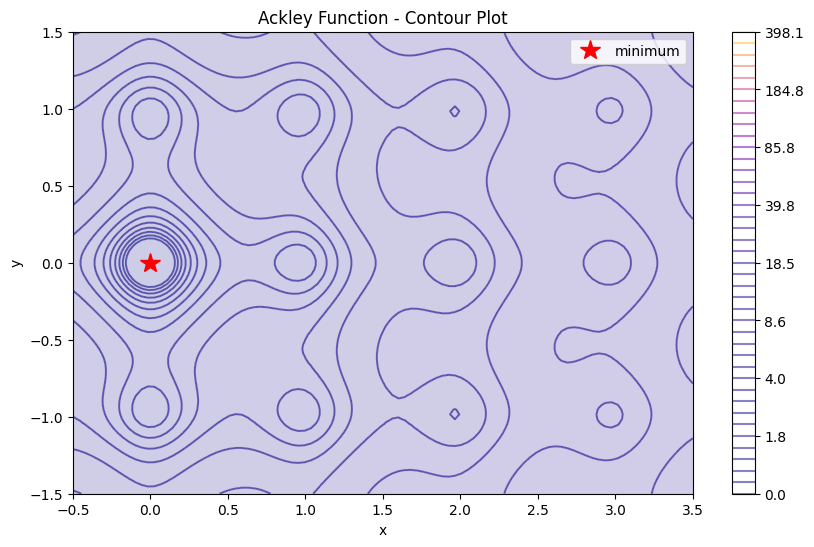

In [19]:
X, Y, Z = gen_2d_loss_surface(ackley)
fig, ax = make_contour_plot(X, Y, Z, cmap='plasma', title="Ackley Function - Contour Plot")
ax.plot(0, 0, 'r*', ms=15, label='minimum')
ax.legend()

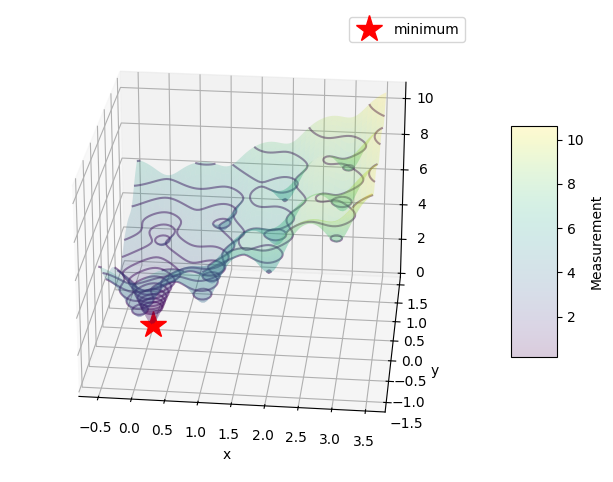

In [20]:
#run: "auto"
elevation = 25 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 276 #@param {type:"slider", min:0, max:360, step:1}

X, Y, Z = gen_2d_loss_surface(ackley)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([0], [0], 'r*', zs=[0], zdir='z', ms=20, label='minimum')
ax.legend()
plt.show()

As you can see, the ackley function is highly non-convex with multiple local minimas, which makes this a useful function for testing optimization algorithms.

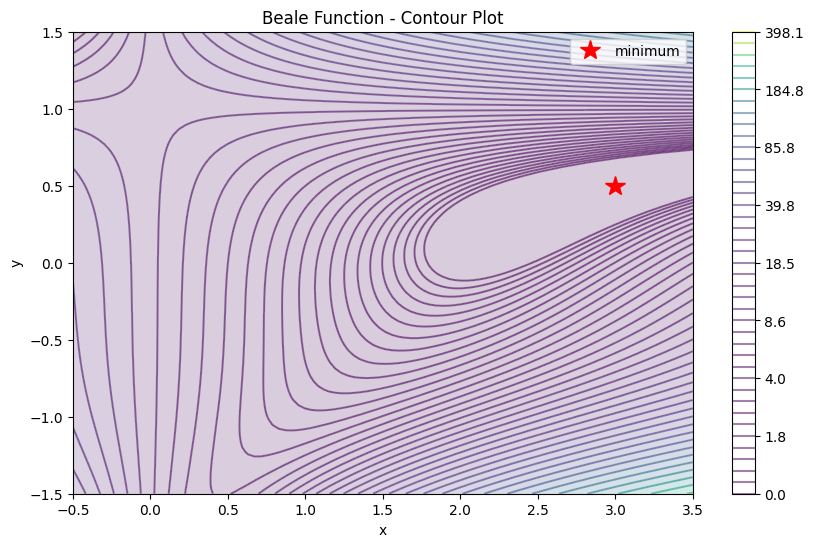

In [21]:
X, Y, Z = gen_2d_loss_surface(beale)
fig, ax = make_contour_plot(X, Y, Z, cmap='viridis', title="Beale Function - Contour Plot")
ax.plot(3, 0.5, 'r*', ms=15, label='minimum')
ax.legend()

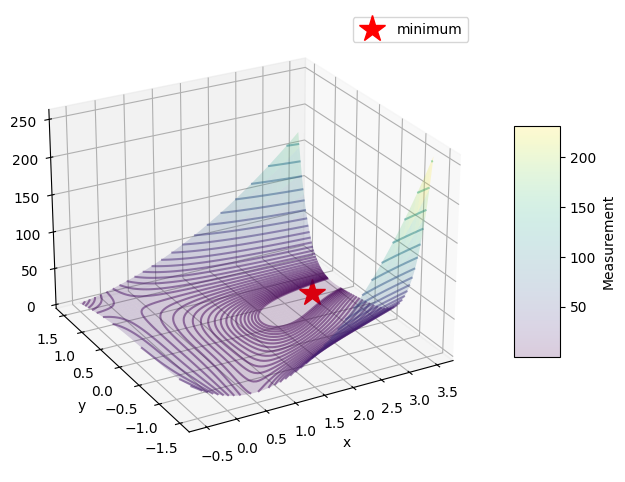

In [22]:
#run: "auto"
elevation = 25 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 241 #@param {type:"slider", min:0, max:360, step:1}

X, Y, Z = gen_2d_loss_surface(beale)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([3], [0.5], 'r*', zs=[0], zdir='z', ms=20, label='minimum')
ax.legend();

As you can see, within the valley, we have a global minimum. Finding the valley is relatively easy, but finding the global minimum is difficult, which makes this a useful function for testing optimization algorithms.

## Optimization
In this section I will implement one step parameters update of some common optimization methods used in deep learning, and apply them trying to optimize ackley and beale functions.

In [23]:
def optimize_loss(loss_func, update_func, params, states, hyper_params, is_first_order):
  # plot the loss surface, minimum value and starting point
  X, Y, Z = gen_2d_loss_surface(loss_func)
  fig, ax = make_contour_plot(X, Y, Z)
  if loss_func == ackley:
    ax.plot(0, 0, 'r*', ms=20, label='minimum')
  elif loss_func == beale:
    ax.plot(3, 0.5, 'r*', ms=20, label='minimum')
  ax.plot(start_x, start_y, 'b*', ms=20, label='start')

  for epoch in range(epochs):
    loss = loss_func(x, y)

    # save the old x and y values for the plot
    old_x = params[0].detach().numpy().copy()
    old_y = params[1].detach().numpy().copy()

    # update the parameters based on the order of the optimization method
    if is_first_order:
      # calculate the gradients of the loss with respect to the params
      grads = torch.autograd.grad(loss, params, create_graph=True)
      update_func(params, grads, states, hyper_params)

    else:
      # calculate the gradients of the loss with respect to the params
      # then calculate the hessian matrix of the loss with respect to the params

    #   grads = torch.autograd.grad(loss, params, create_graph=True)
    #   hessian = torch.zeros((len(params), len(params)), dtype=torch.float32)
    #   for i, grad in enumerate(grads):
    #       for j, param in enumerate(params):
    #           if grad.require_grad:
    #               hessian[i][j] = torch.autograd.grad(grad, param, retain_graph=True)[0]
                  
    # or we can write:
      hessian = torch.autograd.functional.hessian(loss, tuple(params))            
      update_func(params, grads, hessian, states, hyper_params)

    # plot the change in x and y for each update step
    ax.annotate('', xy=(x.detach().numpy().copy(), y.detach().numpy().copy()),
                xytext=(old_x, old_y),
              arrowprops={'arrowstyle': '->', 'color': 'k', 'lw': 1},
                   va='center', ha='center')

  ax.plot(x.detach().numpy(), y.detach().numpy(), 'g*', ms=20, label='end')
  ax.legend()

### Gradient descent
Gradient descent is the simplest of training algorithms commonly used in deep learning. However, it gives excellent results in many cases, and also forms the basis for many other powerful optimization methods - such as Momentum, RMSProp, and Adam - which we will look at later in this notebook. Mathematically we can describe gradient descent as follows:

\begin{equation}
\mathbf{θ}= \mathbf{θ} −\eta \times \nabla_\mathbf{θ} J(\mathbf{θ})
\end{equation}

where $\mathbf{θ}$ are the parameters of the model, $\eta$ (eta) is the learning rate, $J(\mathbf{θ})$ is the loss (also called $\mathcal{L}$), and $\nabla_\theta J(\mathbf{θ})$ is the **gradient** of the loss with respect to the parameters. This equation tells us that to update each of the parameters, we scale the gradient for each parameter by the learning rate and subtract it from the corresponding parameter.

In [24]:
def GD_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01
  # GD doesn't have any state, so you don't need it here
  for param, grad in zip(params, grads):
    param.data = param.data - hyper_params['lr'] * grad

We try different hyperparameters using the sliders below to gain some insights about the performance of the optimization method in diverse situations.

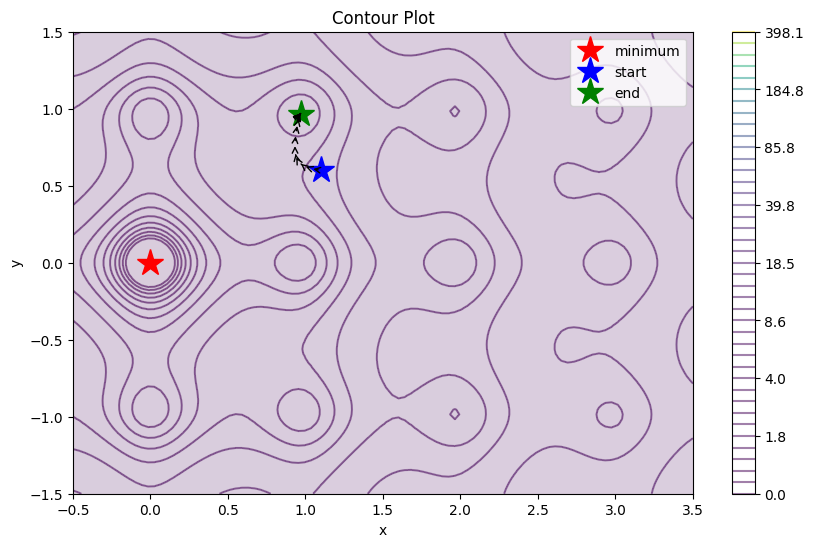

In [25]:
#@title {run: "auto"}
start_x = 1.1 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.6  #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.017 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 88 #@param {type:"slider", min:1, max:150, step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
states = []
hyper_params = {"lr": learning_rate}

optimize_loss(ackley, GD_update, params, states, hyper_params, is_first_order)

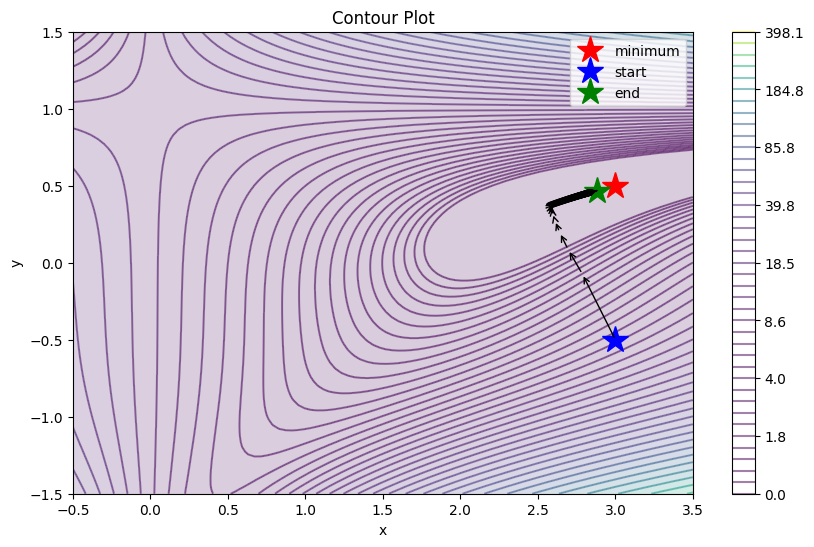

In [26]:
#@title {run: "auto"}
start_x = 3 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = -0.5  #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.02 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 150 #@param {type:"slider", min:1, max:150, step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
states = []
hyper_params = {"lr": learning_rate}

optimize_loss(beale, GD_update, params, states, hyper_params, is_first_order)